# Credit Card Fraud Detection

This project aims to detect credit card fraud.

#### **Description**
This dataset contains credit card transactions made by European cardholders in the year 2023. It comprises over 550,000 records, and the data has been anonymized to protect the cardholders' identities. The primary objective of this dataset is to facilitate the development of fraud detection algorithms and models to identify potentially fraudulent transactions.

#### **Key features of the data:**
*   `id:` Unique identifier for each transaction
*   `V1-V28:` Anonymized features representing various transaction attributes (e.g., time, location, etc.)
*   `Amount:` The transaction amount
*   `Class:` Binary label indicating whether the transaction is fraudulent (1) or not (0)

##### **Source:**
The dataset is from: https://www.kaggle.com/datasets/nelgiriyewithana/credit-card-fraud-detection-dataset-2023


#### Support for the project

* Throughout the project I've used Yann-Aël Le Borgne and Patrick Chong github repository for support and insight on how to approach this problem in a good way. So definetly check their repo out.Link: https://github.com/Fraud-Detection-Handbook/fraud-detection-handbook?tab=readme-ov-file
* I've also used Adrien Payong and Abdeladim Fadheli's article on the subject. You can read their article at this link: https://thepythoncode.com/article/credit-card-fraud-detection-using-sklearn-in-python


In [24]:
# Standard imports
import numpy as np
import pandas as pd

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Tensorflow imports
from tensorflow.keras.models import Sequential

# Importing and exploring the data

You could use the Kaggle API for continouus updates, but it is just easier to do it manually. Therefore you could check if the data has been updated before using this. 

In [25]:
credit_df = pd.read_csv("data/creditcard.csv")
credit_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [26]:
print("Average Amount in a Fraudulent Transaction: ", credit_df[credit_df["Class"] == 1]["Amount"].mean())
print("Average Amount in a Valid Transaction: ", credit_df[credit_df["Class"] == 0]["Amount"].mean())

Average Amount in a Fraudulent Transaction:  122.21132113821139
Average Amount in a Valid Transaction:  88.29102242231328


**NOTE**
The high amount is most likely due to anonymization and confidentiality issues. Otherwise, it seems unlikely that the average amount is this high. Therefore, in a real world application this might effect the performance of the model I'll build in this notebook.

Due to the anonymization it is hard to make useful plots for insight into the data, so I've landed on just using a correlation matrix without reading to much into it.

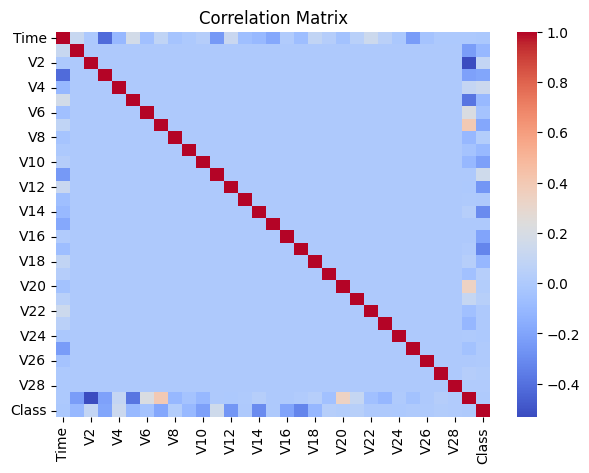

In [27]:
plt.figure(figsize=(7, 5))
sns.heatmap(credit_df.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Matrix');

Judging by the correlation matrix, it seems the last 10 anonomous columns are not highly correlated to much of the data.

# Preparing the data for training

After importing the data we need to make sure there are no issues which will cause problems later on.

### First issues to tackle:
* Check for empty cells or NaN
* Check the distribution of targets (0 or 1)
* Scale the time and amount columns
* Shuffle the data
* Split into training and test sets

In [28]:
# Check for empty cells or NaN
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Good, there seems to be noe empty cells. And the columns V1-V28 are already normalized.

In [29]:
class_counts = credit_df['Class'].value_counts()
print(class_counts)

Class
0    284315
1       492
Name: count, dtype: int64


In [30]:
print("Summary of the feature - Amount" + "\n-------------------------------")
print(credit_df["Amount"].describe())

Summary of the feature - Amount
-------------------------------
count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64


Scale the time and amount columns with RobustScaler from sklearn

In [31]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler().fit(credit_df[["Time", "Amount"]])
credit_df[["Time", "Amount"]] = scaler.transform(credit_df[["Time", "Amount"]])

In [43]:
# Shuffle the dataset
credit_df = credit_df.sample(frac=1, random_state=42).reset_index(drop=True)

from sklearn.model_selection import train_test_split

X = credit_df.drop(columns=['Class'])
y = credit_df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(227845, 30) (227845,) (56962, 30) (56962,)


# Building the framework

This will be the finished model, but when building this I will have tried different approaches.

## 1. Baseline model

I'll be using a baseline model as a refernce point to help me decide if the more complex models improve performance substantially. The baseline model can also highlight data issues early. This will be used as the minimum performance benchmark, and will prevent unnecessary model complexity. For this I'll be using sklearn function, but the other ones I'll build from scratch to maximize understanding and learning potential.

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))

# ROC-AUC score
roc_auc_baseline = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC Score:", roc_auc_baseline)


Classification Report:
               precision    recall  f1-score   support

   Non-Fraud       1.00      0.97      0.99     56863
       Fraud       0.06      0.90      0.11        99

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.97      0.99     56962

ROC-AUC Score: 0.9637819909877311


## 2. Functions for model

### 2.1 Performance metrics

*   `Precision:` The proportion of correctly predicted positive cases out of all cases predicted as positive, indicating model reliability in positive predictions.
*   `Recall:` The proportion of actual positive cases that the model correctly identifies, measuring sensitivity to true positives.
*   `F1-score:` The harmonic mean of precision and recall, balancing both metrics to handle class imbalance effectively.
*   `AUC:` Measures the model’s overall classification performance by calculating the True Positive Rate (TPR) and False Positive Rate (FPR) across thresholds, then finding the area under the ROC curve.

In [34]:
def checkanswers(y_true, y_pred):
    TP = FP = TN = FN = 0
    for true, pred in zip(y_true, y_pred):
        if true == 1 and pred == 1:
            TP += 1
        elif true == 0 and pred == 0:
            TN += 1
        elif true == 0 and pred == 1:
            FP += 1
        elif true == 1 and pred == 0:
            FN += 1
    cm = np.array([[TN, FP], [FN, TP]])
    return cm

In [35]:
def precision_recall_f1(cm):
    TP = cm[1, 1]  # True Positives
    FP = cm[0, 1]  # False Positives
    FN = cm[1, 0]  # False Negatives
    
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0
    
    return precision, recall, f1_score

def roc_curve_and_auc(y_true, y_scores):
    thresholds = np.linspace(0, 1, 100)
    tpr_list, fpr_list = zip(*[
        (
            sum((y_pred := (y_scores >= t)) & y_true) / sum(y_true),
            sum(y_pred & ~y_true) / sum(~y_true)
        )
        for t in thresholds
    ])
    return np.trapz(tpr_list, fpr_list)


### 2.2 Building first suggestion for model: Autoencoder + DNN

I'll use a hybrid model with an `Autoencoder` and a standard neural network `(DNN)` to detect creditcard fraud. The Autoencoder will flag high-reconstruction-error transactions as potential fraud. Then use the DNN on flagged transactions for further classification refinement.

#### Activation and Loss functions :

In [36]:
# Activation functions
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Loss functions
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def binary_cross_entropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true)*np.log(1 - y_pred))


# Initializer to improve gradient time
def xavier_init(size):
    return np.random.randn(*size) * np.sqrt(2 / (size[0] + size[1]))

Now we want to build the autoencoder model. EXPLAINATION:::::

In [44]:
class Autoencoder:
    def __init__(self, input_dim, hidden_dims):
        self.weights = []
        self.biases = []
        
        # Encoder layers
        prev_dim = input_dim
        for h_dim in hidden_dims:
            self.weights.append(xavier_init((prev_dim, h_dim)))
            self.biases.append(np.zeros((1, h_dim)))
            prev_dim = h_dim

        # Decoder layers (symmetrical)
        for h_dim in reversed(hidden_dims[:-1]):
            self.weights.append(xavier_init((prev_dim, h_dim)))
            self.biases.append(np.zeros((1, h_dim)))
            prev_dim = h_dim
        
        # Output layer
        self.weights.append(xavier_init((prev_dim, input_dim)))
        self.biases.append(np.zeros((1, input_dim)))

    def forward(self, x):
        self.activations = [x]
        for i, (w, b) in enumerate(zip(self.weights, self.biases)):
            x = np.dot(x, w) + b
            x = relu(x)
            self.activations.append(x)
            print(f"Layer {i+1} activation shape: {x.shape}")
        return x

    def backward(self, x, learning_rate=0.01):
        delta = (self.activations[-1] - x) * relu_derivative(self.activations[-1])
        for i in range(len(self.weights) - 1, -1, -1):
            grad_w = np.dot(self.activations[i].T, delta) / x.shape[0]
            grad_b = np.mean(delta, axis=0, keepdims=True)
            delta = np.dot(delta, self.weights[i].T) * relu_derivative(self.activations[i])
            self.weights[i] -= learning_rate * grad_w
            self.biases[i] -= learning_rate * grad_b

    def train(self, x, epochs, learning_rate=0.01):
        x = np.array(x)
        for epoch in range(epochs):
            output = self.forward(x)
            loss = mean_squared_error(x, output)
            self.backward(x, learning_rate)
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {loss}")
        return loss